## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Defining auxiliary functions

Show features' importance as bar chart.

In [2]:
def feature_importance(dataframe, classifier):

    importances = classifier.feature_importances_
    features = dataframe.columns

    for feat, importance in zip(features, importances):
        print('{}, importance: {:.2f}'.format(feat, importance))

    plt.figure()
    plt.title("Feature importances")
    plt.bar(x=features, height=importances, align="center")
    plt.show()

Function to compute a **random search** setting up a grid of parameter values
and select random combinations to train the model.

Finally the combination with the **best score is retrieved**, with a *DataFrame*
containing all the combinations with their respective scores.

**N.B.** For scoring we have used two metrics: *accuracy* and *f1_score*

In [3]:
def pprint_combinations(comb):

    print("--------------")

    for idx, c in comb.iterrows():
        print(c['params'])
        print("ACC: {:.3f} \t F1: {:.3f}".format(c['accuracy'], c['f1_score']))

    print("--------------")

In [4]:
from sklearn.model_selection import RandomizedSearchCV

def grid_search(classifier, param_distributions, x, y, n_iter=50):
    gsa = RandomizedSearchCV(classifier, param_distributions=param_distributions,
                             n_iter=n_iter, n_jobs=10,
                             scoring='accuracy')

    gsf1 = RandomizedSearchCV(classifier, param_distributions=param_distributions,
                              n_iter=n_iter, n_jobs=10,
                              scoring='f1_weighted')

    gsa.fit(x,y)
    gsf1.fit(x,y)

    # build the final dataframe, starting from the first search's results
    dfres = pd.DataFrame(gsa.cv_results_)
    dfres.rename(columns={'mean_test_score':'accuracy'}, inplace=True)

    # add to the dataframe also the second score (f1_score)
    dfres['f1_score'] = gsf1.cv_results_['mean_test_score']

    # sort the dataframe by the "accuracy" score
    # (because we'll show the best results)
    dfres.sort_values(by='accuracy', ascending=False, inplace=True)

    # select only the interesting attributes
    dfres = dfres[['params', 'accuracy', 'f1_score']]

    # print('Best setting parameters ', gsa.best_params_)
    pprint_combinations(dfres[:5])
    return gsa.best_params_

## Loading the data set

The data set is assigned to a Pandas data frame.

In [5]:
df = pd.read_csv('data/new_df.csv', index_col=0, decimal='.')

## Defining classification labels

After sorting the dataset by `SumExp`, we have splitted it in 3 equal parts.
 - **First third** of customers is*_low spending*
 - **Second third** of customers is *medium spending*
 - **Last third** is *high spending*

In [6]:
df.sort_values(by='SumExp', inplace=True)

length = len(df)
l1 = length // 3
l2 = l1*2
df['Label'] = "low"
df.loc[df.index[l1:l2], 'Label'] = "medium"
df.loc[df.index[l2:], 'Label'] = "high"

## Deleting columns

We have dropped columns that won't be used in predictive analysis

In [7]:
df.drop(columns=['Iu', 'Imax', 'SumExp', 'AvgExp'], axis=1, inplace=True)

## Splitting Dataset

We have divided the dataset into *train* and *test* sets
(70% - 30% respectively)

In [8]:
from sklearn.model_selection import train_test_split

label = df.pop('Label')
train_set, test_set, train_label, test_label = train_test_split(df, label, stratify=label, test_size=0.3, random_state=42)

train_label_cat = train_label.astype('category').cat.codes
test_label_cat = test_label.astype('category').cat.codes

print('Train set size: ', len(train_set))
print('Test set size: ', len(test_set))

Train set size:  2919
Test set size:  1252


### Function for reporting scores of predictive analysis

In [9]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
import statistics
from yellowbrick.classifier import classification_report as cr, confusion_matrix as cm

def report_scores(classifier, test_pred, feat=True, conf_mat=True, report=True):

    # feature importance
    if feat:
        feature_importance(df, classifier)
        print('\n')

    # scores
    scores = cross_validate(classifier, train_set, train_label, cv=3, return_train_score= True, scoring='accuracy')

    print('Fit time ', statistics.mean(scores['fit_time']))
    print('Score time ', statistics.mean(scores['score_time']))
    print('Train score ', statistics.mean(scores['train_score']))
    print('Test score ', statistics.mean(scores['test_score']))
    print('\n')

    classes = ['high', 'low', 'medium']

    # confusion matrix
    if conf_mat:
        cm(classifier, train_set, train_label, test_set, test_label,
        classes=classes)

        plt.tight_layout()


    # classification report
    if report:
        print(classification_report(test_label, test_pred))
        cr(classifier, train_set, train_label, test_set, test_label,
           classes=classes, support=True)

        plt.show()

# Predictive Analysis

Almost all the used techniques follow this pattern:
 - Define the **classifier**
 - **Fit** the model with the *train set*
 - **Predict** on the *test set*, using the fitted classifier
 - Compute **performances** of the model, showing some statistics and metrics

## Naive Bayes

Fit time  0.004513184229532878
Score time  0.0029992262522379556
Train score  0.682939362795478
Test score  0.6827680712572799




C:\Users\tajam\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


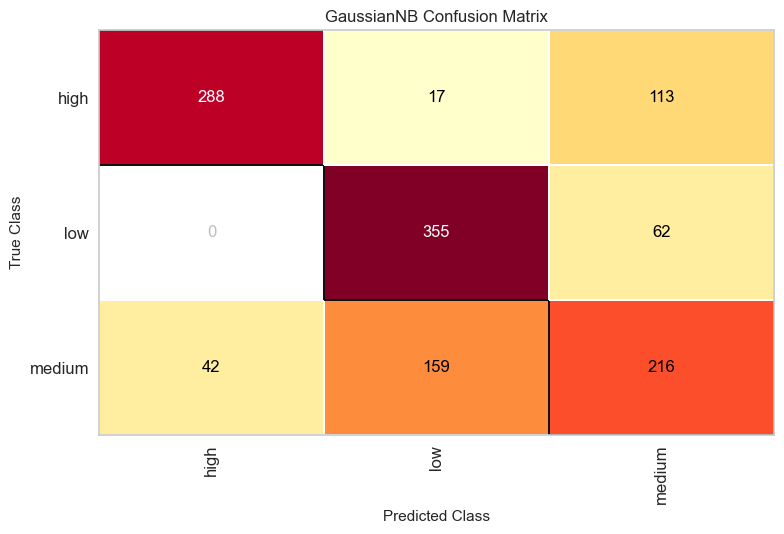

              precision    recall  f1-score   support

        high       0.87      0.69      0.77       418
         low       0.67      0.85      0.75       417
      medium       0.55      0.52      0.53       417

    accuracy                           0.69      1252
   macro avg       0.70      0.69      0.68      1252
weighted avg       0.70      0.69      0.68      1252



C:\Users\tajam\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
C:\Users\tajam\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tajam\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tajam\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarn

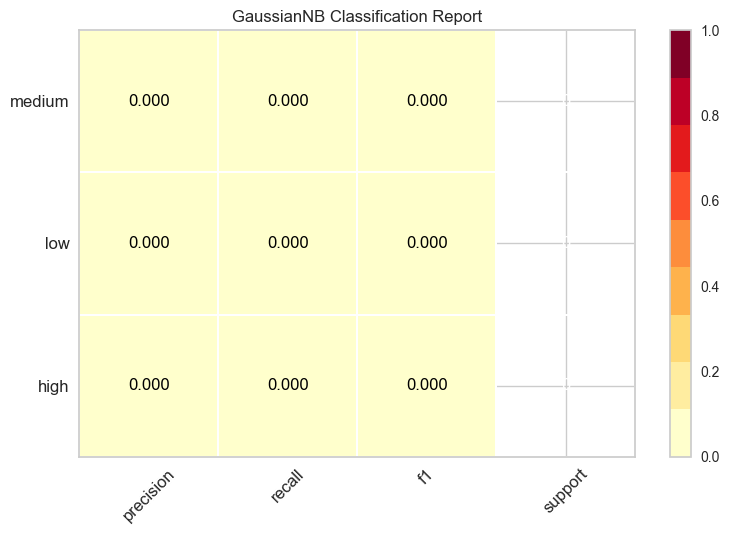

In [10]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(train_set, train_label)

test_pred_gnb = gnb.predict(test_set)

report_scores(gnb, test_pred_gnb, feat=False)

## Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from scipy.stats import randint as sp_randint

param_dist = {"max_depth": [2,3,4,5,6,7,8,9,10,11,12,None],
              "min_samples_split": sp_randint(3, 30),
              "min_samples_leaf": sp_randint(1, 40),
              "criterion": ["entropy", "gini"],
              "splitter": ["best", "random"]}

clf = DecisionTreeClassifier()

best_params = grid_search(clf, param_dist, train_set, train_label)

--------------
{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 36, 'min_samples_split': 23, 'splitter': 'best'}
ACC: 0.752 	 F1: 0.727
{'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 34, 'min_samples_split': 10, 'splitter': 'best'}
ACC: 0.749 	 F1: 0.687
{'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 15, 'min_samples_split': 15, 'splitter': 'best'}
ACC: 0.745 	 F1: 0.741
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 21, 'min_samples_split': 20, 'splitter': 'best'}
ACC: 0.744 	 F1: 0.740
{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 18, 'splitter': 'best'}
ACC: 0.743 	 F1: 0.725
--------------


I, importance: 0.20
Entropy, importance: 0.25
BasketNum, importance: 0.55


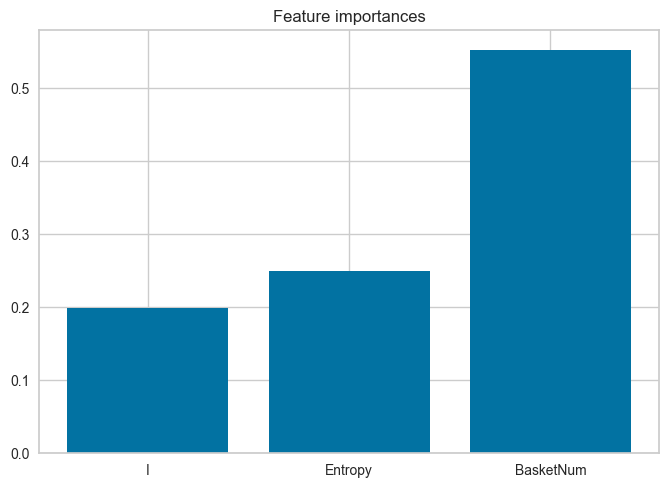



Fit time  0.006630897521972656
Score time  0.0027892589569091797
Train score  0.7687564234326825
Test score  0.7475162726961289




C:\Users\tajam\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


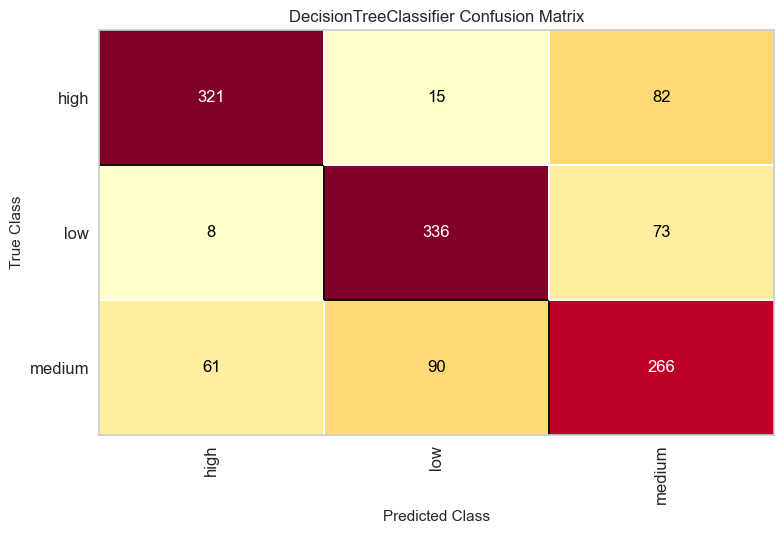

              precision    recall  f1-score   support

        high       0.82      0.77      0.79       418
         low       0.76      0.81      0.78       417
      medium       0.63      0.64      0.63       417

    accuracy                           0.74      1252
   macro avg       0.74      0.74      0.74      1252
weighted avg       0.74      0.74      0.74      1252



C:\Users\tajam\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\tajam\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tajam\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tajam\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: Undefin

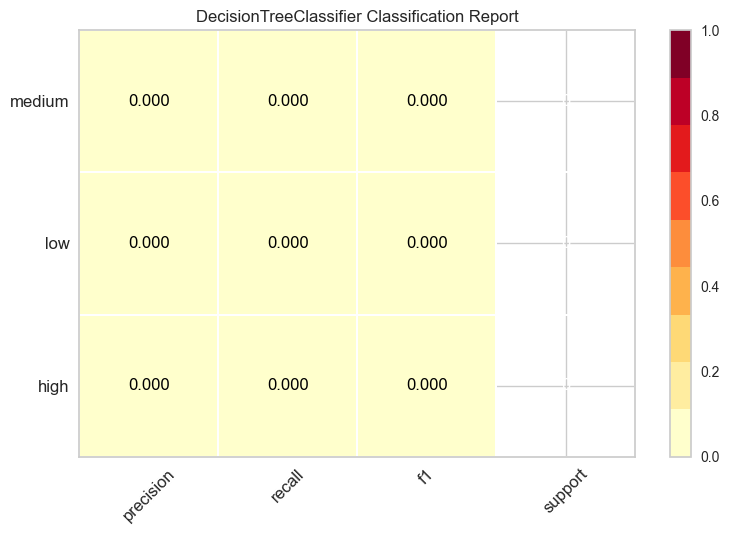

In [12]:
dt = DecisionTreeClassifier(**best_params)

dt = dt.fit(train_set, train_label)

test_pred_dt = dt.predict(test_set)

report_scores(dt, test_pred_dt)

In [ ]:
%pip install pydotplus
# visualize the obtained decision tree
import pydotplus
from IPython.display import Image

dot_data = export_graphviz(dt, out_file=None, max_depth=3,
                           feature_names=list(train_set.columns),
                           filled=True, rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

ModuleNotFoundError: No module named 'pydotplus'

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_dist = {"n_estimators": [30,50,100,300,500,750,1000],
              "max_depth": [2,3,4,5,6,7,8,9,10,11,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(3, 30),
              "min_samples_leaf": sp_randint(4, 30),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None]}

clf = RandomForestClassifier()

best_params = grid_search(clf, param_dist, train_set, train_label)

--------------
{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 25, 'min_samples_split': 26, 'n_estimators': 300}
ACC: 0.762 	 F1: 0.741
{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 24, 'min_samples_split': 7, 'n_estimators': 100}
ACC: 0.759 	 F1: 0.746
{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 1, 'min_samples_leaf': 9, 'min_samples_split': 10, 'n_estimators': 300}
ACC: 0.759 	 F1: 0.760
{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 1, 'min_samples_leaf': 12, 'min_samples_split': 8, 'n_estimators': 30}
ACC: 0.759 	 F1: 0.748
{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 11, 'max_features': 1, 'min_samples_leaf': 19, 'min_samples_split': 13, 'n_estimators': 1000}
ACC: 0.758 	 F1: 0.755
----------

I, importance: 0.24
Entropy, importance: 0.26
BasketNum, importance: 0.50


Fit time  0.7537476221720377
Score time  0.05324594179789225
Train score  0.777149708804385
Test score  0.7533401849948612


              precision    recall  f1-score   support

        high       0.82      0.79      0.80       418
         low       0.78      0.81      0.79       417
      medium       0.64      0.65      0.64       417

    accuracy                           0.75      1252
   macro avg       0.75      0.75      0.75      1252
weighted avg       0.75      0.75      0.75      1252



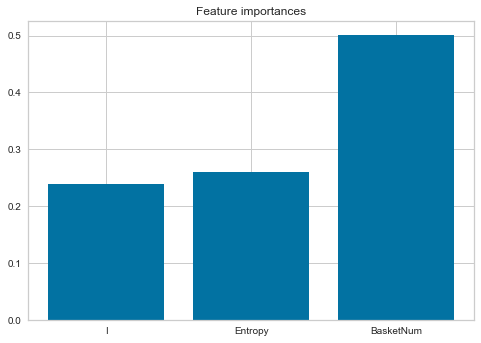

/Users/Jacopo/Desktop/dm_prj/venv/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/Users/Jacopo/Desktop/dm_prj/venv/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


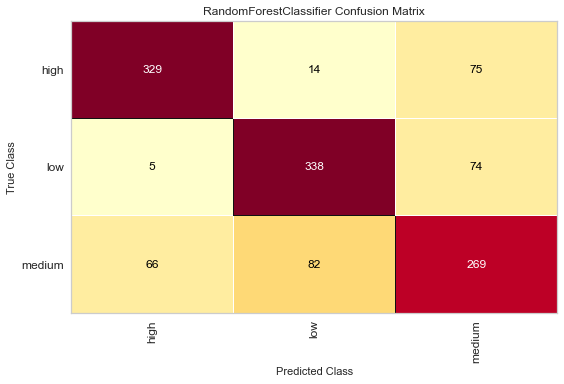

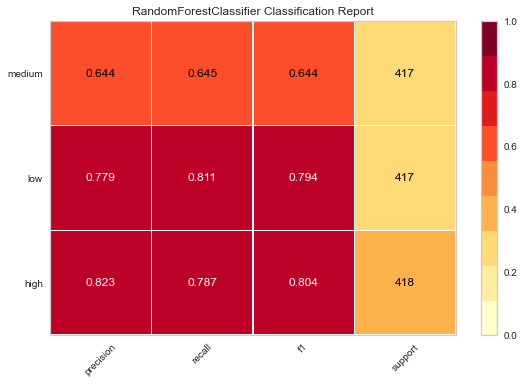

In [ ]:
rf = RandomForestClassifier(**best_params)

rf = rf.fit(train_set, train_label)

test_pred_rf = rf.predict(test_set)

report_scores(rf, test_pred_rf)

## KNN

For KNN we didn't perform model selection. We checked the error rate for
k = 1 to k = 40. For every value of _k_ we called the *KNN classifier*
and then chosen the value which had the least error rate.

Text(0, 0.5, 'Error Rate')

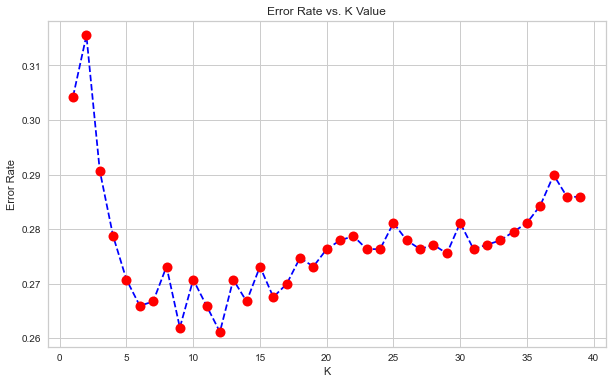

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []
max_i = 40
for i in range(1,max_i):

    knn = KNeighborsClassifier(n_neighbors=i, algorithm='auto')
    knn = knn.fit(train_set, train_label)
    pred_i = knn.predict(test_set)
    error_rate.append(np.mean(pred_i != test_label))

plt.figure(figsize=(10,6))
plt.plot(range(1,max_i), error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

Fit time  0.003920952479044597
Score time  0.032768567403157554
Train score  0.7600205549845838
Test score  0.7303871188763275


              precision    recall  f1-score   support

        high       0.79      0.79      0.79       418
         low       0.76      0.82      0.79       417
      medium       0.66      0.60      0.63       417

    accuracy                           0.74      1252
   macro avg       0.74      0.74      0.74      1252
weighted avg       0.74      0.74      0.74      1252



/Users/Jacopo/Desktop/dm_prj/venv/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/Users/Jacopo/Desktop/dm_prj/venv/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


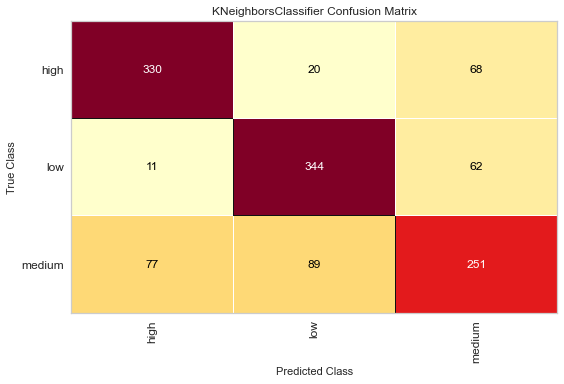

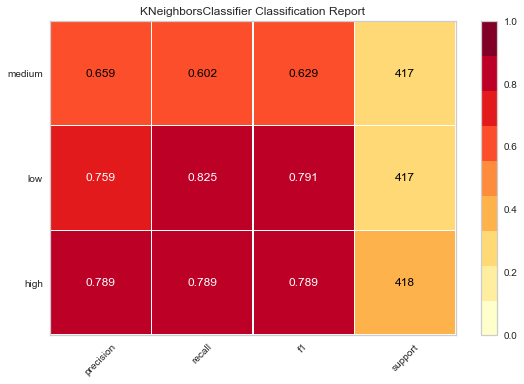

In [ ]:
knn = KNeighborsClassifier(n_neighbors=12, algorithm='auto')

knn = knn.fit(train_set, train_label)

test_pred_knn = knn.predict(test_set)

report_scores(knn, test_pred_knn, feat=False)

## SVM

In [ ]:
from sklearn.svm import SVC

param_dist = {"kernel": ['linear', 'poly', 'rbf', 'sigmoid']}

clf = SVC()

best_params = grid_search(clf, param_dist, train_set, train_label)

/Users/Jacopo/Desktop/dm_prj/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/Jacopo/Desktop/dm_prj/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


--------------
{'kernel': 'linear'}
ACC: 0.729 	 F1: 0.728
{'kernel': 'rbf'}
ACC: 0.700 	 F1: 0.699
{'kernel': 'sigmoid'}
ACC: 0.586 	 F1: 0.579
{'kernel': 'poly'}
ACC: 0.569 	 F1: 0.547
--------------


Fit time  1.2131713231404622
Score time  0.013216177622477213
Train score  0.7273038711887633
Test score  0.7266187050359713


              precision    recall  f1-score   support

        high       0.84      0.78      0.81       418
         low       0.73      0.80      0.77       417
      medium       0.60      0.58      0.59       417

    accuracy                           0.72      1252
   macro avg       0.72      0.72      0.72      1252
weighted avg       0.72      0.72      0.72      1252



/Users/Jacopo/Desktop/dm_prj/venv/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/Users/Jacopo/Desktop/dm_prj/venv/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


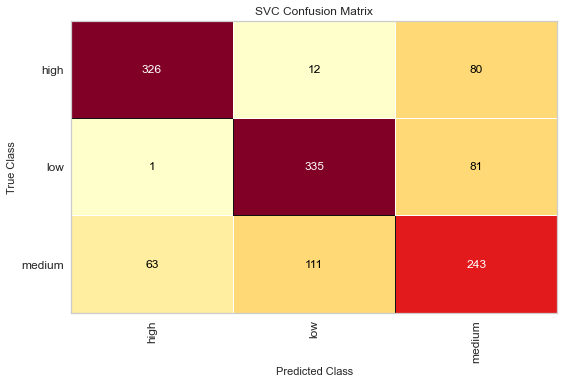

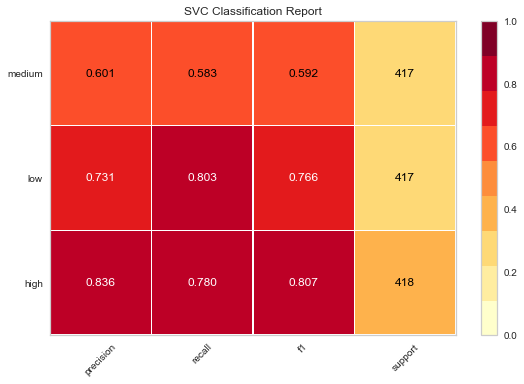

In [ ]:
svm = SVC( **best_params)

svm = svm.fit(train_set, train_label)

test_pred_svm = svm.predict(test_set)

report_scores(svm, test_pred_svm, feat=False)